In [112]:
#NOTE FOR USER: 
#You must run all the sections in chronological order for this program to work unless the section is noted as "OPTIONAL"
#Your statement must be saved as a .csv file in order to be read by the program

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
import re
import operator

#this is to avoid running into deprecation with a datetime converter in the section that graphs balances ("the date2num function")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [113]:
#This section will import and "clean" your data. Replace the example directory given below with the location of your statement,
#saved as a .csv file. Make sure to keep the quotes.

df = pd.read_csv(r'C:\Users\Trevor\Documents\bank_program\Export.csv', header=3, sep=',', error_bad_lines=False)
df['Date'] = pd.to_datetime(df.Date)
df = df.fillna(0)
df['year_month'] = df['Date'].dt.to_period('M')
df.sort_values(by=['Date'])
df.head()

,Transaction Number,Date,Description,Memo,Amount Debit,Amount Credit,Balance,Check Number,Fees,year_month
0,1284875,2019-08-13,Deposit EBENEZER AME CHU,ID: 9002028683 CO: EBENEZER AME CHU,0.0,137.02,14030.10,0.0,0.0,2019-08
1,1179237,2019-08-13,Deposit PAYPAL,ID: PAYPALSD11 CO: PAYPAL,0.0,662.50,13893.08,0.0,0.0,2019-08
2,1179234,2019-08-13,Deposit VENMO,ID: 5264681992 CO: VENMO,0.0,30.00,13230.58,0.0,0.0,2019-08
3,1306354,2019-08-08,Withdrawal,0,-593.0,0.00,13200.58,0.0,0.0,2019-08
4,1279011,2019-08-06,Deposit EBENEZER AME CHU,ID: 9002028683 CO: EBENEZER AME CHU,0.0,137.03,13793.58,0.0,0.0,2019-08


In [114]:
#OPTIONAL 

#If you have outliers that you would like to exclude from calculations, enter threshhold amount below, under the "threshold 
#variable". Any transaction above that amount will be removed from your statement and the processing of it.

#Examples could include buying a car, putting a down payment on a house, or withdrawing and then depositing a large sum of money,
#which would be indistinguishable from income.

threshold = 1000000

rows_to_delete = []
for item in df.iterrows():
    if abs(item[1].get('Amount Debit')) >= threshold or abs(item[1].get('Amount Credit')) >= threshold:
        rows_to_delete.append(item[0])
        #item[0] is the index of the row. Will use list to delete all rows that have a credit/debit greater than or equal to 
        #threshold.
df = df.drop(rows_to_delete, axis=0)

In [115]:
#This is the section where all the data is processed

#in month_hash, each month is a "sub-hash", containing key/value pairs for expenditures, income, and balance for that month
#all_balances will be a list of tuples that store date and account balance for every transaction

month_hash = {}
all_balances = []

for item in df.iterrows():
    date = str(item[1].get('year_month').month) + ' ' + str(item[1].get('year_month').year)
    if date not in month_hash:
        month_hash[date] = {'income': item[1].get('Amount Credit'), 'expenditures': item[1].get('Amount Debit'), 'balance': item[1].get('Balance')}
        all_balances.append((item[1].get('Date'), item[1].get('Balance')))
    else: 
        month_hash[date]['income'] += item[1].get('Amount Credit')
        month_hash[date]['expenditures'] -= item[1].get('Amount Debit')
        all_balances.append((item[1].get('Date'), item[1].get('Balance')))
        
        
months = list(month_hash.keys())
incomes = []
expenditures = [] 
balances = []

for month in months:
    incomes.append(month_hash[month]['income'])
    expenditures.append(month_hash[month]['expenditures'])
    balances.append(month_hash[month]['balance'])

months.reverse()  #reversing each list so graphs start with oldest month first
incomes.reverse()
expenditures.reverse()
balances.reverse()
all_balances.reverse()

ypos = np.arange(len(incomes))
plt.figure(figsize=(16,6))
plt.bar(ypos, incomes, width=.5, align='center', alpha=.5, color='g')
plt.bar(ypos + .5, expenditures, width=.5, align='center', alpha=.5, color='r')
plt.xticks(ypos, months)
plt.ylabel('Money in Dollars')
plt.title('Monthly Income/Expenditures')
variables = ['Income', 'Expenditures']
plt.legend(variables, loc=9)
plt.show

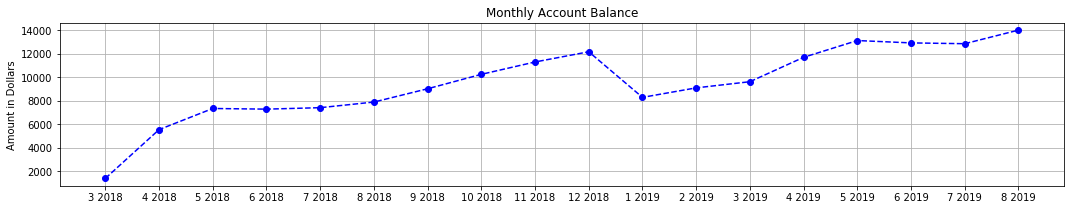

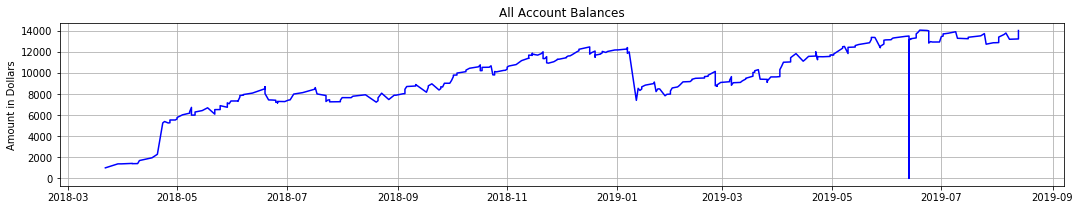

In [116]:
#This section provides two graphs, one that tracks account balances from the end of each month and one that tracks each change
#in account balance.

x_axis_monthly = range(0, len(months))
plt.figure(figsize = (len(months), 3))
plt.plot(x_axis_monthly, balances, '--bo')
plt.grid(True)
plt.ylabel('Amount in Dollars')
plt.xticks(x_axis_monthly, months)
plt.title("Monthly Account Balance")
plt.show()

#balance_dates stores a list of all the balance entries' dates converted into an integer (the "date2num" function)
balance_dates = matplotlib.dates.date2num([i[0] for i in all_balances])
plt.figure(figsize = (len(months), 3))
plt.grid(True)
plt.ylabel('Amount in Dollars')
plt.title("All Account Balances")
plt.plot_date(balance_dates, [i[1] for i in all_balances], '-b');


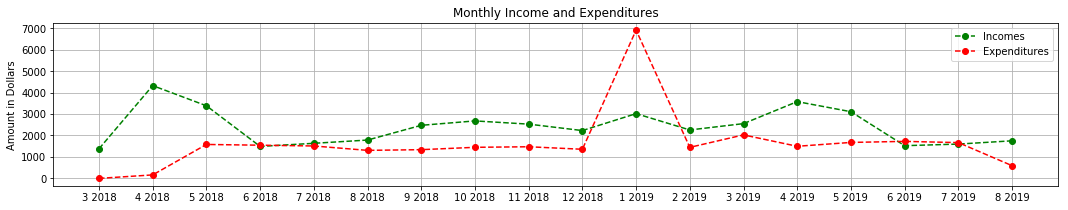

In [117]:
#This section will graph your incomes and expenditures on the same plot.

plt.figure(figsize=(len(months),3))
plt.plot(x_axis_monthly, incomes, '--go', label='Incomes')
plt.plot(x_axis_monthly, expenditures, '--ro', label='Expenditures')
plt.legend()
plt.title('Monthly Income and Expenditures')
plt.ylabel("Amount in Dollars")
plt.grid(True)
plt.xticks(x_axis_monthly, months)
plt.show()

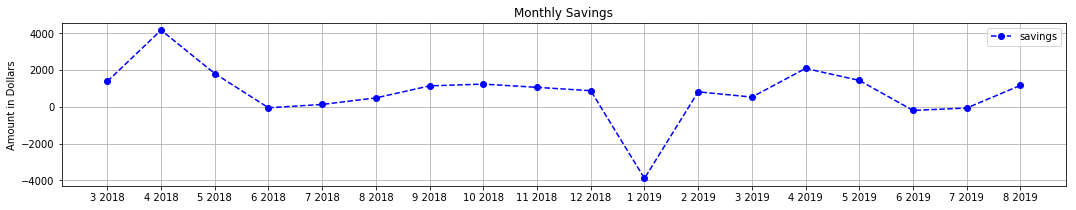

In [118]:
#Plots your montly savings.

savings = list(map(lambda income, expense: income - expense, incomes, expenditures))

plt.figure(figsize=(len(months),3))
plt.plot(x_axis_monthly, savings, '--bo', label='savings')
plt.legend()
plt.title("Monthly Savings")
plt.ylabel("Amount in Dollars")
plt.grid(True)
plt.xticks(x_axis_monthly, months)
plt.show()

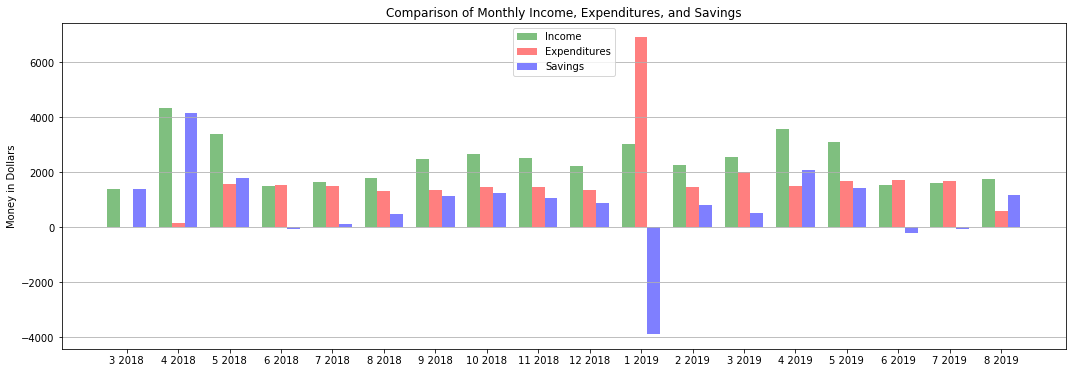

In [119]:
#This section produces a bar graph that shows monthly, income, expenditures, and savings side by side.

#this code is responsible for producing the offset for each variable so that the bars are not literally on top of each other
x_left = list(map(lambda x: x -.25, x_axis_monthly))
x_right = list(map(lambda x: x +.25, x_axis_monthly))

plt.figure(figsize=(len(months), 6))
plt.bar(x_left, incomes, width=.25, align='center', alpha=.5, color='g')
plt.bar(x_axis_monthly, expenditures, width=.25, align='center', alpha=.5, color='r')
plt.bar(x_right, savings, width=.25, align='center', alpha=.5, color='b')
plt.grid(True, axis='y')
plt.xticks(x_axis_monthly, months)
plt.ylabel('Money in Dollars')
plt.title('Comparison of Monthly Income, Expenditures, and Savings')
variables = ['Income', 'Expenditures', 'Savings']
plt.legend(variables, loc=9)
plt.show();

In [120]:
#This section will sort your yearly income by source, which is particularly useful if you are a freelancer or have lots of 
#discrete income sources. The next section will graph it.

income_source_hash = {}
source_matcher = re.compile("(?<=Deposit ).*$")
atm_catcher = re.compile('^at ATM #[0-9]*$')

for item in df.iterrows():
    if item[1].get('Amount Credit'):
        amount = item[1].get('Amount Credit')
        year = item[1].get('year_month').year
        match_object = source_matcher.search(str(item[1].get('Description')))
        
        #the following set of if statements group all ATM transactions together, create separate entries for other unique 
        #descriptions and assumes cash desposit if there was no description for the credit (which is how Mazuma stores their data)
        
        if match_object and atm_catcher.match(match_object.group(0)):
            description = 'ATM Deposit'
        elif match_object:
            description = match_object.group(0)
        else:
            description = 'Cash Deposit'
        if year in income_source_hash:
            if description in income_source_hash[year]:
                income_source_hash[year][description] += amount
            else:
                income_source_hash[year][description] = amount
        else:
            income_source_hash[year] = {description: amount}

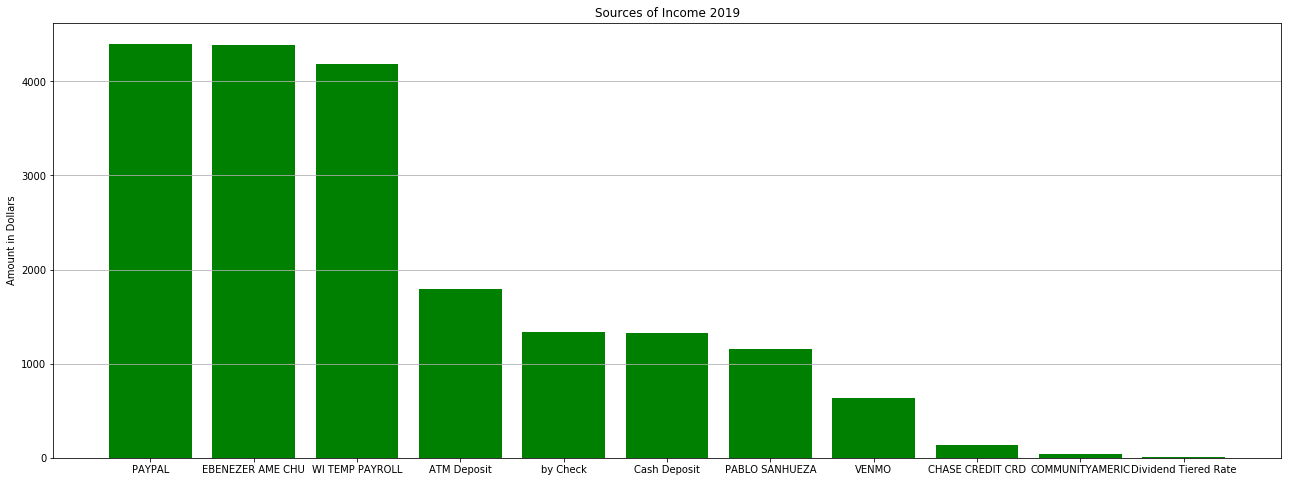

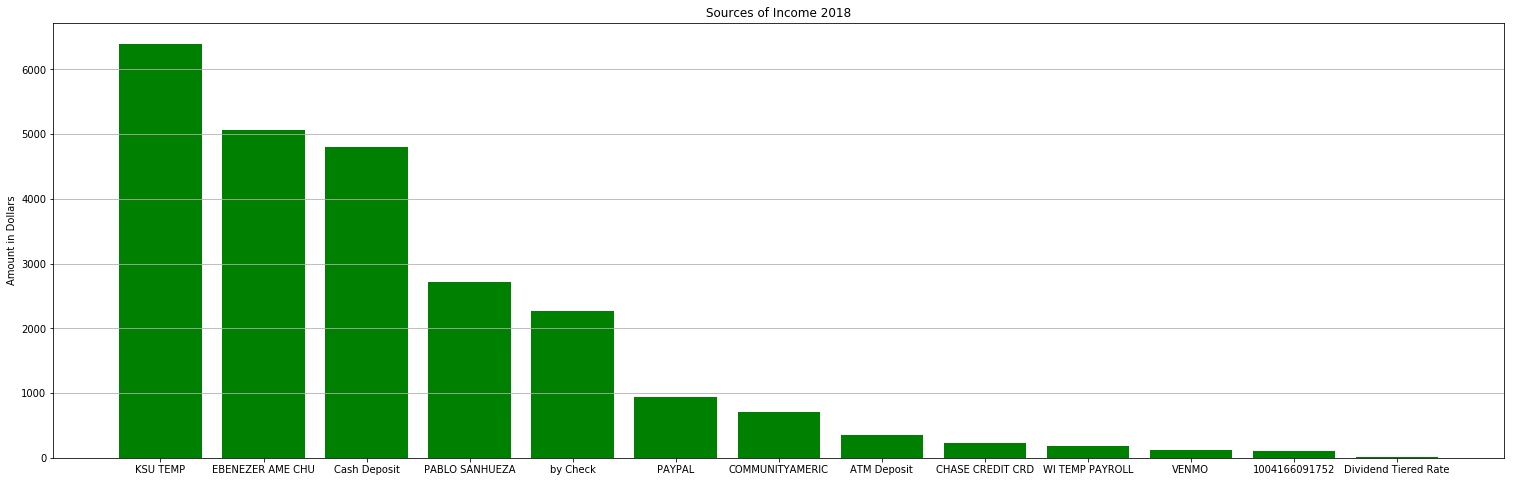

In [121]:
#This section produces a bar graph for each year in your statement, displaying the amount of income from every source.

for year in income_source_hash:
    sorted_income_tuples = sorted(income_source_hash[year].items(), key=operator.itemgetter(1), reverse=True)
    plt.figure(figsize = (len(income_source_hash[year]) * 2, 8))
    plt.bar([item[0] for item in sorted_income_tuples], [item[1] for item in sorted_income_tuples], color='g')
    plt.grid(True, axis='y')
    plt.ylabel('Amount in Dollars')
    plt.title('Sources of Income ' + str(year))
    plt.show();